**CURSO**: Análisis Geoespacial, Departamento de Geociencias y Medio Ambiente, Universidad Nacional de Colombia - sede Medellín <br/>
**Profesor**: Edier Aristizábal (evaristizabalg@unal.edu.co) <br />
**Credits**: The content of this notebook is taken from several sources, such as [Muntasir Wahed](https://medium.com/analytics-vidhya/the-beginners-guide-to-choropleth-maps-in-python-ff1da28a8943), [Ander Fernández Jauregui](https://anderfernandez.com/en/blog/kmeans-algorithm-python/?utm_source=en&utm_medium=email), but specially from the courses and book open and freely published by [Dani Arribas-Bel](http://darribas.org/) -  University of Liverpool & - Sergio Rey - [Center for Geospatial Sciences, University of California, Riverside](http://spatial.ucr.edu/peopleRey.html). Every effort has been made to trace copyright holders of the materials used in this book. The author apologies for any unintentional omissions and would be pleased to add an acknowledgment in future editions. 

In [1]:
import warnings
warnings.filterwarnings("ignore")

# Non-spatial clustering

This session covers statistical clustering of spatial observations. Many questions and topics are complex phenomena that involve several dimensions and are hard to summarize into a single variable. In statistical terms, we call this family of problems *multivariate*, as oposed to *univariate* cases where only a single variable is considered in the analysis. Clustering tackles this kind of questions by reducing their dimensionality -the number of relevant variables the analyst needs to look at- and converting it into a more intuitive set of classes that even non-technical audiences can look at and make sense of. For this reason, it is widely use in applied contexts such as policy making or marketting. In addition, since these methods do not require many preliminar assumptions about the structure of the data, it is a commonly used exploratory tool, as it can quickly give clues about the shape, form and content of a dataset.

The basic idea of statistical clustering is to summarize the information contained in several variables by creating a relatively small number of categories. Each observation in the dataset is then assigned to one, and only one, category depending on its values for the variables originally considered in the classification. If done correctly, the exercise reduces the complexity of a multi-dimensional problem while retaining all the meaningful information contained in the original dataset. This is because, once classified, the analyst only needs to look at in which category every observation falls into, instead of considering the multiple values associated with each of the variables and trying to figure out how to put them together in a coherent sense.

Although there exist many techniques to statistically group observations in a dataset, all of them are based on the premise of using a set of attributes to define classes or categories of observations that are similar *within* each of them, but differ *between* groups. How similarity within groups and dissimilarity between them is defined and how the classification algorithm is operationalized is what makes techniques differ and also what makes each of them particularly well suited for specific problems or types of data. As an illustration, we will only dip our toes into one of these methods, K-means, which is probably the most commonly used technique for statistical clustering.

## K-Means

The k-Means algorithm finds those k points (called centroids) that minimize the root of the sum of squared errors. This process is done iteratively until the total error is not reduced anymore. At that time we will have reached a minimum and our observations will be classified into different groups or clusters.

Thus, the K-means algorithm consists of the following steps:

* We initialize k centroids randomly.
* Calculate the root of the sum of squared deviations.
* Assign a centroid to each of the observations.
* Calculate the sum of total errors and compare it with the sum in the previous iteration.
* If the error decreases, recalculate centroids and repeat the process.

As you can see, at a conceptual level it is a very simple algorithm, although you will see how we are going to find some more complicated points. In any case, to see how it works, I will first need some data on which to use the k-means algorithm in Python.

To do this, we are going to create a function that, given some coordinates, a radius, and a number of data, will create that amount of data randomly distributed around the chosen center. In this way, we will create three differentiated groups in which, it may be that data from different groups are close together, thus giving rise to certain errors.

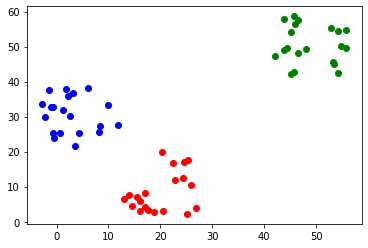

In [1]:
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
np.random.seed(123)

def circulo(num_datos = 100,R = 1, minimo = 0,maximo= 1, center_x = 0 , center_y = 0):
    pi = math.pi
    r = R * np.sqrt(np.random.uniform(minimo, maximo, size = num_datos)) 
    theta = np.random.uniform(minimo, maximo, size= num_datos) * 2 * pi

    x = center_x + np.cos(theta) * r
    y = center_y + np.sin(theta) * r

    x = np.round(x,3)
    y = np.round(y,3)

    df = np.column_stack([x,y])
    df = pd.DataFrame(df)
    df.columns = ['x','y']
    return(df)

# Create data
datos_1 = circulo(num_datos = 20,R = 10, center_x = 5, center_y = 30)
datos_2 = circulo(num_datos = 20,R = 10, center_x = 20, center_y = 10)
datos_3 = circulo(num_datos = 20,R = 10, center_x = 50, center_y = 50)

data = datos_1.append(datos_2).append(datos_3)

plt.scatter(datos_1['x'], datos_1['y'], c = 'b')
plt.scatter(datos_2['x'], datos_2['y'], c = 'r')
plt.scatter(datos_3['x'], datos_3['y'], c = 'g')
plt.show()

As we can see, we have three well-differentiated groups of data. Our goal will be to create a k-means algorithm in Python that is capable of solving this problem and group them correctly. Following the explanation above, the first step in creating our kmeans algorithm in Python will be to calculate the root of the sum of squared errors. So, let’s go for it!

First of all, we must initialize k centroids randomly. This is not much of a mystery. However, to make the allocation process faster, it is interesting that the centroids are within the range of the data itself. This will help the algorithm to converge earlier, similar to what happens in the parameter initiation of other algorithms, such as neural networks.

So, we create a function in which, given some data and a centroid quantity, it initializes them:

In [ ]:
def initialize_centroids(k, data):

    n_dims = data.shape[1]
    centroid_min = data.min().min()
    centroid_max = data.max().max()
    centroids = []

    for centroid in range(k):
        centroid = np.random.uniform(centroid_min, centroid_max, n_dims)
        centroids.append(centroid)

    centroids = pd.DataFrame(centroids, columns = data.columns)

    return centroids

centroids = initialize_centroids(3, data)
centroids

,x,y
0,52.833388,9.953092
1,15.168107,29.151304
2,52.622571,57.644971


Now that we have our centroids, we must learn to calculate the error. Surely, you have heard that the k-means algorithm consists of measuring distance. Actually, this is not the case, the k-means algorithm seeks to minimize the root of the sum of squared errors. This indicator can be calculated as follows:

<img src="https://anderfernandez.com/wp-content/uploads/2020/06/image-5.png.webp">

That is why many times we get confused, although now you know that k-means is not based on distance. In fact, if the k-means algorithm was based on distances, we could use another type of distance measurement (as in the kNN algorithm), but this is not the case.

In any case, we can create a function that calculates the root of the sum of squared errors:

In [ ]:
def calculate_error(a,b):
    '''
    Given two Numpy Arrays, calculates the root of the sum of squared errores.
    '''
    error = np.square(np.sum((a-b)**2))

    return error 

Since we already have the centroids, the data and the way to calculate the error, we can check that our error works correctly. To do this, we simply have to obtain the errors of the 3 centroids to an observation and visually compare it:

In [ ]:
errors = np.array([])
for centroid in range(centroids.shape[0]):
    error = calculate_error(centroids.iloc[centroid, :2], data.iloc[0,:2])
    errors = np.append(errors, error)

errors

array([ 9239109.47028511,    76100.30291143, 15797406.01662303])

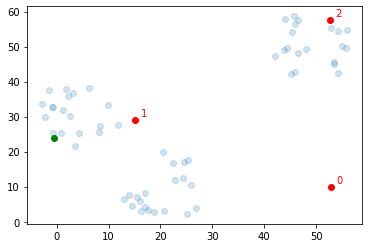

In [ ]:
plt.scatter(data.iloc[1:,0], data.iloc[1:,1],  marker = 'o', alpha = 0.2)
plt.scatter(centroids.iloc[:,0], centroids.iloc[:,1],  marker = 'o', c = 'r')
plt.scatter(data.iloc[0,0], data.iloc[0,1],  marker = 'o', c = 'g')
for i in range(centroids.shape[0]):
    plt.text(centroids.iloc[i,0]+1, centroids.iloc[i,1]+1, s = centroids.index[i], c = 'r')

Indeed, after performing the visual check, we see how effectively the second centroid (index 1) is the one that is closest to the rest of the observations. So our error function seems to be working fine.

So now that we know how to find the closest centroid, let’s continue programming the k-means function in Python. Following the previous steps, for each of the observations, we must find the centroid that is closest to it.

In [ ]:
np.where(errors == np.amin(errors))[0].tolist()[0]

1

So we must apply this same process to all observations. As it will be a recurring thing, it is best to define it as a function.

In [ ]:
def assign_centroid(data, centroids):
    '''
    Receives a dataframe of data and centroids and returns a list assigning each observation a centroid.
    data: a dataframe with all data that will be used.
    centroids: a dataframe with the centroids. For assignment the index will be used.
    '''

    n_observations = data.shape[0]
    centroid_assign = []
    centroid_errors = []
    k = centroids.shape[0]


    for observation in range(n_observations):

        # Calculate the errror
        errors = np.array([])
        for centroid in range(k):
            error = calculate_error(centroids.iloc[centroid, :2], data.iloc[observation,:2])
            errors = np.append(errors, error)

        # Calculate closest centroid & error 
        closest_centroid =  np.where(errors == np.amin(errors))[0].tolist()[0]
        centroid_error = np.amin(errors)

        # Assign values to lists
        centroid_assign.append(closest_centroid)
        centroid_errors.append(centroid_error)

    return (centroid_assign,centroid_errors)

data['centroid'], data['error'] = assign_centroid(data.iloc[:,:2] ,centroids)
data[['centroid', 'error']].head()

,centroid,error
0,1,76100.302911
1,1,3810.746835
2,1,18034.697838
3,1,71229.148068
4,1,36703.174251


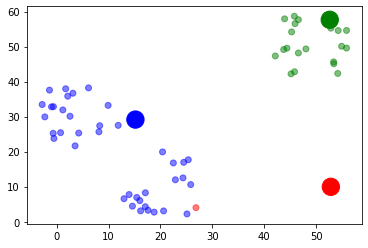

In [ ]:
colors = {0:'red', 1:'blue', 2:'green'}

plt.scatter(data.iloc[:,0], data.iloc[:,1],  marker = 'o', c = data['centroid'].apply(lambda x: colors[x]), alpha = 0.5)
plt.scatter(centroids.iloc[:,0], centroids.iloc[:,1],  marker = 'o', s=300, 
           c = centroids.index.map(lambda x: colors[x]))

As we can see, the closest points have been assigned for each of the centroids. Now that we know how to assign a centroid to each observation, let’s continue programming our kmeans algorithm in Python.

Calculating the sum of total errors is very simple. As we have already stored the error of the operation in a column, simply adding the errors will give us the total number of errors:

In [ ]:
data['error'].sum()

7089622.406081449

We must compare this sum with the result of the previous iteration. In our case, it is the first iteration so we will always continue.

Also, comment that generally the match with the previous error must be exact. This would mean that our centroids have not moved, since they have reached a point that minimizes the error.

In any case, this is something we’ll see when we put it all together. At the moment, we continue to program our kmeans algorithm in Python. Let’s see how to recalculate centroids!

If the previous point has not been fulfilled, that is, if the total error has decreased, we will have to recalculate the position of the centroids to repeat the process . To recalculate the centroids we simply have to calculate the mean position of the centroid as an average of its variables.

As in the data frame data we have the information of the observation and the centroids that has been assigned to each observation, it is something that we can do very easily with this data frame:

In [ ]:
data_columns = ['x','y']

centroids = data.groupby('centroid').agg('mean').loc[:,data_columns].reset_index(drop = True)
centroids

,x,y
0,26.831000,4.002000
1,10.902256,19.928974
2,48.898800,50.526050


In fact, we could re-visualize the data and we will see how the centroids have changed their position, placing themselves in the center of the data:

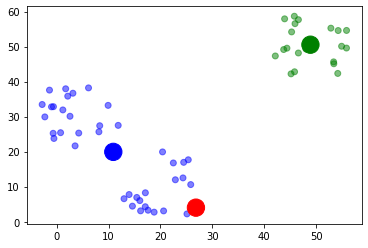

In [ ]:
plt.scatter(data.iloc[:,0], data.iloc[:,1],  marker = 'o', c = data['centroid'].apply(lambda x: colors[x]), alpha = 0.5)
plt.scatter(centroids.iloc[:,0], centroids.iloc[:,1],  marker = 'o', s=300, 
           c = centroids.index.map(lambda x: colors[x]))

Now that we have the centroids recalculated, we should repeat the above process, until the error no longer decreases. So, let’s see how to put everything together and finish creating our kmeans algorithm in Python.

Finally, we simply have to put all the previous process together inside a while loop, in such a way that we create our kmeans algorithm in Python. Let’s get to it!

In [ ]:
def knn(data, k):
    '''
    Given a dataset and number of clusters, it clusterizes the data. 
    data: a DataFrame with all information necessary
    k: number of clusters to create
    '''

    # Initialize centroids and error
    centroids = initialize_centroids(k, data)
    error = []
    compr = True
    i = 0

    while(compr):
        # Obtain centroids and error
        data['centroid'], iter_error = assign_centroid(data,centroids)
        error.append(sum(iter_error))
        # Recalculate centroids
        centroids = data.groupby('centroid').agg('mean').reset_index(drop = True)

        # Check if the error has decreased
        if(len(error)<2):
            compr = True
        else:
            if(round(error[i],3) !=  round(error[i-1],3)):
                compr = True
            else:
                compr = False
        i = i + 1 

    data['centroid'], iter_error = assign_centroid(data,centroids)
    centroids = data.groupby('centroid').agg('mean').reset_index(drop = True)
    return (data['centroid'], iter_error, centroids)

Now we can apply this function to our data. To do this, I must first pass the data by removing the centroid, and error variables that I have previously created.

In [ ]:
data['centroid'], _, centroids =  knn(data.drop(['centroid','error'], axis = 1),3)
data['centroid'].head() 

0    0
1    0
2    0
3    0
4    0
Name: centroid, dtype: int64

Finally, we can check how this clustering has ended visually:

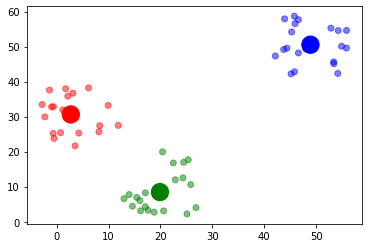

In [ ]:
plt.scatter(data.iloc[:,0], data.iloc[:,1],  marker = 'o', c = data['centroid'].apply(lambda x: colors[x]), alpha = 0.5)
plt.scatter(centroids.iloc[:,0], centroids.iloc[:,1],  marker = 'o', s=300, 
           c = centroids.index.map(lambda x: colors[x]))

## Spatial clustering

The dataset we will use in this occasion is an extract from the online website [AirBnb](http://www.airbnb.com). AirBnb is a company that provides a meeting point for people looking for an alternative to a hotel when they visit a city, and locals who want to rent (part of) their house to make some extra money. The website has a continuously updated listing of all the available properties in a given city that customers can check and book through. In addition, the website also provides a feedback mechanism by which both ends, hosts and guests, can rate their experience. Aggregating ratings from guests about the properties where they have stayed, AirBnb provides additional information for every property, such as an overall cleanliness score or an index of how good the host is at communicating with the guests.

The original data are provided at the property level and for the entire London. However, since the total number of properties is very large for the purposes of this notebook, they have been aggregated at the Middle Super Output Area (MSOA), a geographical unit created by the Office of National Statistics. Although the original source contains information for the Greater London, the vast majority of properties are located in Inner London, so the data we will use is restricted to that extent. Even in this case, not every polygon has at least one property. To avoid cases of missing values, the final dataset only contains those MSOAs with at least one property, so there can be average ratings associated with them.

Our goal in this notebook is to create a classification of areas (MSOAs) in Inner London based on the ratings of the AirBnb locations. This will allow us to create a typology for the geography of AirBnb in London and, to the extent the AirBnb locations can say something about the areas where they are located, the classification will help us understand the geography of residential London a bit better. One general caveat about the conclusions we can draw from an analysis like this one that derives from the nature of AirBnb data. On the one hand, this dataset is a good example of the kind of analyses that the data revolution is making possible as, only a few years ago, it would have been very hard to obtain a similarly large survey of properties with ratings like this one. On the other hand, it is important to keep in mind the kinds of biases that these data are subject to and thus the limitations in terms of generalizing findings to the general population. At any rate, this dataset is a great example to learn about statistical clustering of spatial observations, both in a geodemographic as well as in a regionalization.

Let's start by reading the main table of MSOAs in:

In [3]:
from esda.moran import Moran
import libpysal.weights.set_operations as Wsets
from libpysal.weights import Queen, KNN
import seaborn as sns
from pysal.lib import weights
import geopandas as gpd
import contextily as cx
from sklearn import cluster
from sklearn.cluster import KMeans, AgglomerativeClustering

In [4]:
# Read the file in
abb = gpd.read_file("https://darribas.org/gds_course/content/data/london_abb.gpkg")

URLError: <urlopen error [Errno -2] Name or service not known>

In [ ]:
# Inspect the structure of the table
abb.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 353 entries, 0 to 352
Data columns (total 18 columns):
 #   Column                       Non-Null Count  Dtype   
---  ------                       --------------  -----   
 0   MSOA_CODE                    353 non-null    object  
 1   accommodates                 353 non-null    float64 
 2   bathrooms                    353 non-null    float64 
 3   bedrooms                     353 non-null    float64 
 4   beds                         353 non-null    float64 
 5   number_of_reviews            353 non-null    float64 
 6   reviews_per_month            353 non-null    float64 
 7   review_scores_rating         353 non-null    float64 
 8   review_scores_accuracy       353 non-null    float64 
 9   review_scores_cleanliness    353 non-null    float64 
 10  review_scores_checkin        353 non-null    float64 
 11  review_scores_communication  353 non-null    float64 
 12  review_scores_location       353 non-null    float64 
 1

Before we jump into exploring the data, one additional step that will come in handy down the line. Not every variable in the table is an attribute that we will want for the clustering. In particular, we are interested in review ratings, so we will only consider those. Hence, let us first manually write them so they are easier to subset:

In [ ]:
ratings = ['review_scores_rating', 'review_scores_accuracy', 
           'review_scores_cleanliness', 'review_scores_checkin', 
           'review_scores_communication', 'review_scores_location',
           'review_scores_value']

Later in the section, we will also use what AirBnb calls neighborhoods. Let's load them in so they are ready when we need them.

In [ ]:
boroughs = gpd.read_file("https://darribas.org/gds_course/content/data/london_inner_boroughs.geojson")

Note that, in comparison to previous datasets, this one is provided in a new format, `.geojson`. GeoJSON files are a plain text file (you can open it on any text editor and see its contents) that follows the structure of the JSON format, widely used to exchange information over the web, adapted for geographic data, hence the `geo` at the front. GeoJSON files have gained much popularity with the rise of web mapping and are quickly becoming a de-facto standard for small datasets because they are readable by humans and by many different platforms. As you can see above, reading them in Python is exactly the same as reading a shapefile, for example.

## Getting to know the data

The best way to start exploring the geography of AirBnb ratings is by plotting each of them into a different map. This will give us a univariate perspective on each of the variables we are interested in.

Since we have many columns to plot, we will create a loop that generates each map for us and places it on a "subplot" of the main figure:

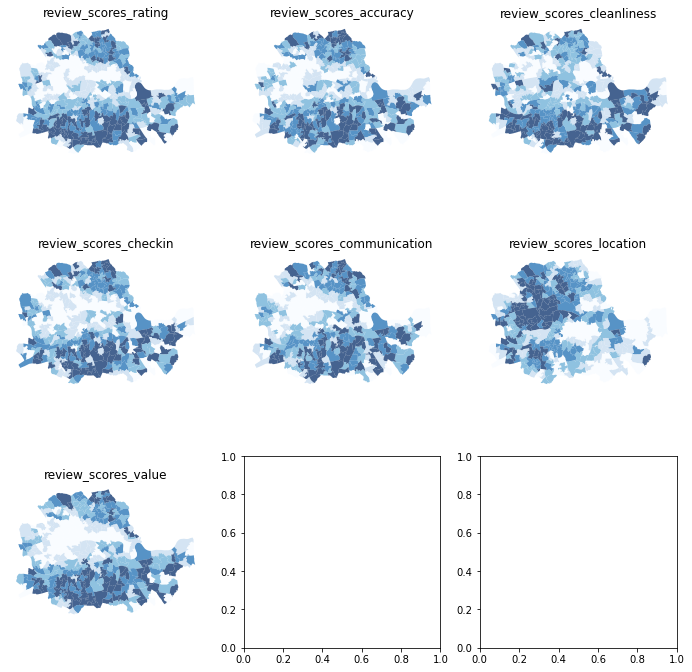

In [ ]:
# Create figure and axes (this time it's 9, arranged 3 by 3)
f, axs = plt.subplots(nrows=3, ncols=3, figsize=(12, 12))
# Make the axes accessible with single indexing
axs = axs.flatten()
# Start the loop over all the variables of interest
for i, col in enumerate(ratings):
    # select the axis where the map will go
    ax = axs[i]
    # Plot the map
    abb.plot(column=col, ax=ax, scheme='Quantiles', \
             linewidth=0, cmap='Blues', alpha=0.75)
    # Remove axis clutter
    ax.set_axis_off()
    # Set the axis title to the name of variable being plotted
    ax.set_title(col)
# Display the figure
plt.show()

As we can see, there is substantial variation in how the ratings for different aspects are distributed over space. While variables like the overall value (`review_scores_value`) or the communication (`review_scores_communication`) tend to higher in peripheral areas, others like the location score (`review_scores_location`) are heavily concentrated in the city centre.

Even though we only have seven variables, it is very hard to "mentally overlay" all of them to come up with an overall assessment of the nature of each part of London. For bivariate correlations, a useful tool is the correlation matrix plot, available in `seaborn`:

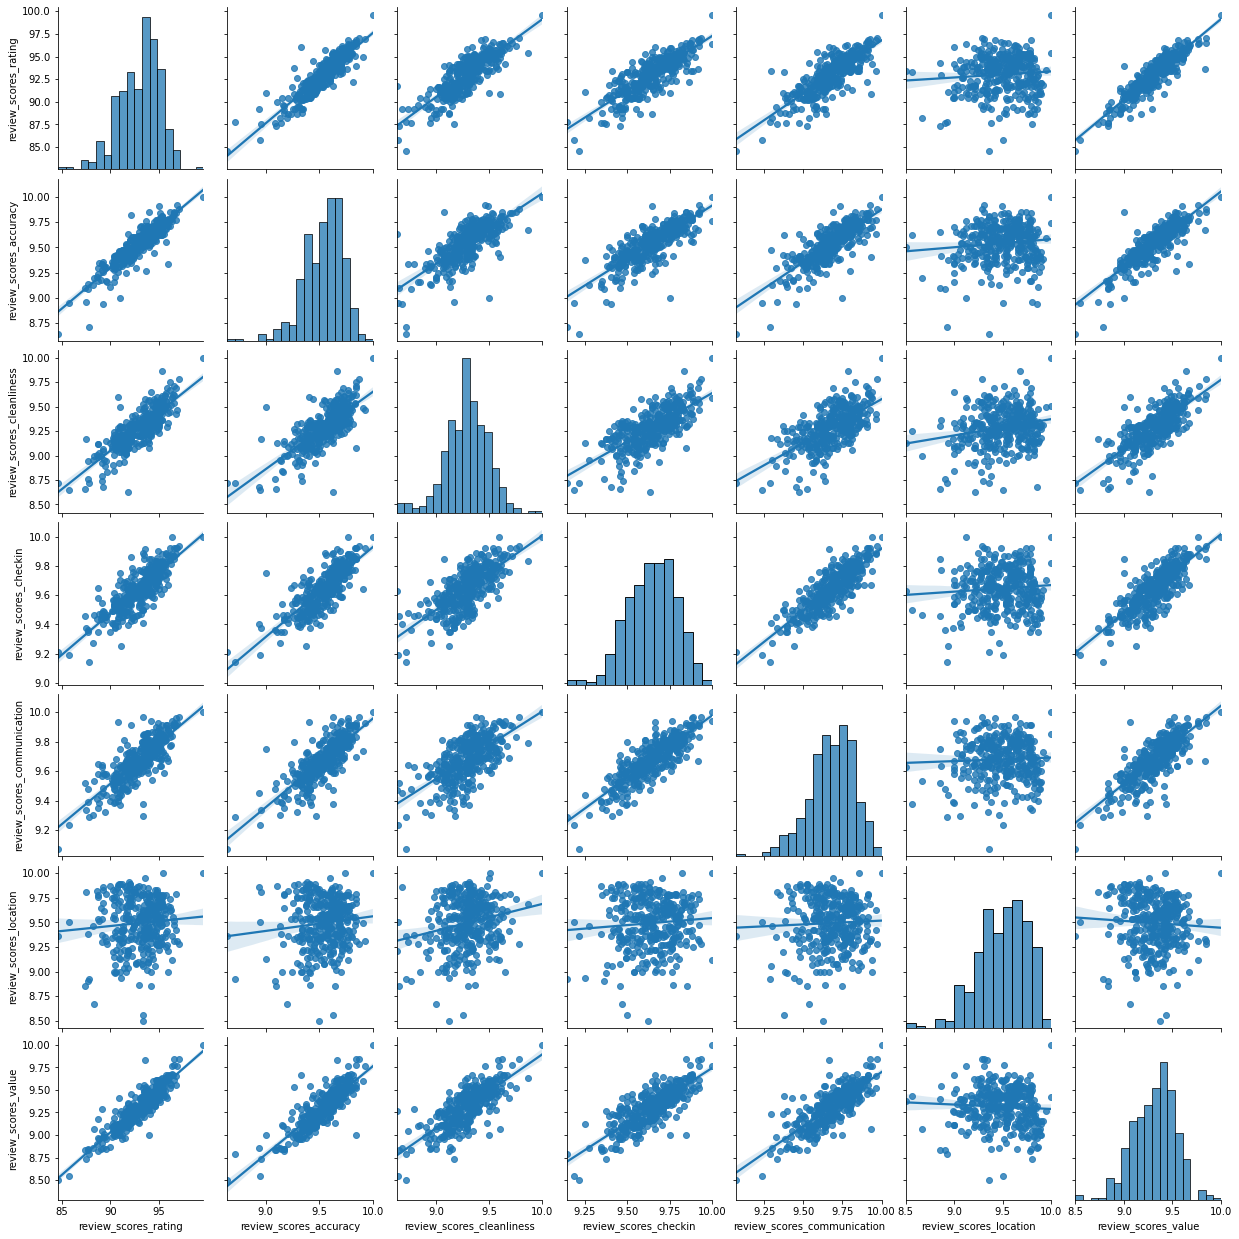

In [ ]:
_ = sns.pairplot(abb[ratings], kind='reg', diag_kind='hist')

Two different types of plots are contained in the scatterplot matrix. On the diagonal are the density functions for the seven attributes. These allow for an inspection of the overall morphology of the attribute’s value distribution. Examining these we see that our selection of variables includes those that are negatively skewed  as well as positively skewed.

The second type of visualization lies in the off-diagonal cells of the matrix; these are bi-variate scatterplots. Each cell shows the association between one pair of variables. Several of these cells indicate positive linear associations while other cells display negative correlation. 

This is helpful to consider uni and bivariate questions such as: *what is the relationship between the overall (`rating`) and location scores?* (Positive) *Are the overall ratings more correlated with location or with cleanliness?* (Cleanliness) However, sometimes, this is not enough and we are interested in more sophisticated questions that are truly multivariate and, in these cases, the figure above cannot help us. For example, it is not straightforward to answer questions like: *what are the main characteristics of the South of London?* *What areas are similar to the core of the city?* *Are the East and West of London similar in terms of the kind of AirBnb properties you can find in them?* For these kinds of multi-dimensional questions -involving multiple variables at the same time- we require a truly multidimensional method like statistical clustering.

Recall from Moran’s I is a commonly used measure for global spatial autocorrelation. Let us get a quick sense to what extent this is present in our dataset. First, we need to build a spatial weights matrix that encodes the spatial relationships in our data. We will start with queen contiguity:

In [ ]:
w = Queen.from_dataframe(abb)

As we have seen before, w does not contain any islands:

In [ ]:
w.islands

[]

Now let’s calculate Moran’s I for the variables being used. This will measure the extent to which each variable contains spatial structure:

In [ ]:
# Set seed for reproducibility
np.random.seed(123456)
# Calculate Moran's I for each variable
mi_results = [Moran(abb[variable], w) for variable in ratings]
# Display on table
table = pd.DataFrame([(variable, res.I, res.p_sim) \
                          for variable,res \
                          in zip(ratings, mi_results)
                         ], columns=['Variable', "Moran's I", 'P-value']
                        )\
              .set_index('Variable')
table

,Moran's I,P-value
Variable,,
review_scores_rating,0.448577,0.001
review_scores_accuracy,0.326009,0.001
review_scores_cleanliness,0.347948,0.001
review_scores_checkin,0.365247,0.001
review_scores_communication,0.357104,0.001
review_scores_location,0.591462,0.001
review_scores_value,0.486141,0.001


Each of the variables displays significant positive spatial autocorrelation, suggesting that Tobler’s law is alive and well in the socioeconomic geography of San Diego County. This means we also should expect the clusters we find will have a non random spatial distribution. In particular, we would expect clusters to have a modest amount of spatial coherence in addition to the coherence in their profiles, since there is strong positive autocorrelation in all of the input variables.

Spatial autocorrelation only describes relationships between a single observation at a time. So, the fact that all of the clustering variables are positively autocorrelated does not tell us about the way the attributes covary over space. For that, we need to consider the spatial correlation between variables. Here, we will measure this using the bivariate correlation in the maps of covariates themselves.

### Classification using K-means

A geodemographic analysis involves the classification of the areas that make up a greographical map into groups or categories of observations that are similar within each other but different between them. The classification is carried out using a statistical clustering algorithm that takes as input a set of attributes and returns the group ("labels" in the terminology) each observation belongs to. Depending on the particular algorithm employed, additional parameters, such as the desired number of clusters employed or more advanced tuning parameters (e.g. bandwith, radius, etc.), also need to be entered as inputs. For our geodemographic classification of AirBnb ratings in Inner London, we will use one of the most popular clustering algorithms: K-means. This technique only requires as input the observation attributes and the final number of groups that we want it to cluster the observations into. In our case, we will use five to begin with as this will allow us to have a closer look into each of them.

K-means is probably the most widely used approach to cluster a dataset. The algorithm groups observations into a prespecified number of clusters so that that each observation is closer to the mean of its own cluster than it is to the mean of any other cluster. The k-means problem is solved by iterating between an assignment step and an update step. First, all observations are randomly assigned one of the k labels. Next, the multivariate mean over all covariates is calculated for each of the clusters. Then, each observation is reassigned to the cluster with the closest mean. If the observation is already assigned to the cluster whose mean it is closest to, the observation remains in that cluster. This assignment-update process continues until no further reassignments are necessary.

The nature of this algorithm requires us to select the number of clusters we want to create. The right number of clusters is unknown in practice. For illustration, we will use k=5 in the K-means implementation from scikit-learn. To proceed, we first create a K-means clusterer. Although the underlying algorithm is not trivial, running K-means in Python is streamlined thanks to `scikit-learn`. Similar to the extensive set of available algorithms in the library, its computation is a matter of two lines of code. First, we need to specify the parameters in the `K-means` method (which is part of `scikit-learn`'s `cluster` submodule). Note that, at this point, we do not even need to pass the data:

In [ ]:
kmeans5 = cluster.KMeans(n_clusters=5)

This sets up an object that holds all the parameters required to run the algorithm. In our case, we only passed the number of clusters (`n_clusters`) and the random state, a number that ensures every run of K-means, which remember relies on random initialisations, is the same and thus reproducible.

To actually run the algorithm on the attributes, we need to call the `fit` method in `kmeans5`:

In [ ]:
# Run the clustering algorithm
k5cls = kmeans5.fit(abb[ratings])

The `k5cls` object we have just created contains several components that can be useful for an analysis. For now, we will use the labels, which represent the different categories in which we have grouped the data. Remember, in Python, life starts at zero, so the group labels go from zero to four. Labels can be  extracted as follows:

In [ ]:
k5cls.labels_

array([2, 3, 3, 3, 0, 0, 3, 4, 2, 4, 0, 4, 2, 4, 4, 4, 3, 0, 0, 2, 2, 2,
       1, 1, 1, 1, 1, 2, 2, 1, 2, 2, 4, 3, 0, 0, 0, 0, 3, 0, 4, 0, 0, 0,
       3, 0, 0, 0, 3, 3, 4, 1, 2, 0, 0, 0, 0, 3, 3, 3, 2, 3, 3, 0, 4, 3,
       3, 3, 3, 3, 3, 3, 3, 0, 3, 0, 3, 3, 0, 0, 0, 0, 3, 3, 0, 3, 4, 4,
       4, 0, 0, 4, 0, 0, 4, 0, 0, 2, 0, 2, 4, 1, 2, 2, 4, 0, 0, 4, 2, 3,
       0, 0, 0, 0, 0, 0, 4, 0, 0, 0, 3, 0, 4, 0, 0, 0, 0, 0, 0, 3, 3, 2,
       4, 2, 4, 4, 2, 0, 0, 4, 0, 4, 3, 0, 1, 4, 4, 2, 1, 1, 2, 2, 4, 4,
       4, 4, 2, 4, 4, 4, 4, 3, 0, 0, 4, 3, 3, 3, 3, 3, 3, 3, 0, 4, 3, 3,
       3, 3, 3, 0, 3, 0, 3, 3, 3, 3, 3, 3, 3, 3, 0, 1, 4, 0, 4, 0, 3, 0,
       3, 0, 0, 0, 3, 0, 0, 3, 3, 4, 3, 2, 3, 3, 3, 3, 1, 0, 4, 3, 0, 3,
       3, 0, 1, 3, 3, 4, 0, 2, 0, 4, 0, 0, 4, 2, 4, 3, 2, 2, 4, 2, 2, 0,
       2, 4, 4, 0, 0, 0, 4, 0, 0, 4, 3, 0, 3, 3, 3, 4, 3, 3, 3, 0, 0, 0,
       0, 4, 4, 2, 0, 4, 2, 1, 3, 2, 4, 1, 2, 1, 3, 2, 4, 2, 1, 2, 4, 2,
       2, 0, 4, 2, 1, 4, 0, 0, 0, 0, 0, 3, 0, 0, 3,

Each number represents a different category, so two observations with the same number belong to same group. The labels are returned in the same order as the input attributes were passed in, which means we can append them to the original table of data as an additional column:

In [ ]:
abb['k5cls'] = k5cls.labels_

### Mapping the categories

To get a better understanding of the classification we have just performed, it is useful to display the categories created on a map. For this, we will use a unique values choropleth, which will automatically assign a different color to each category:

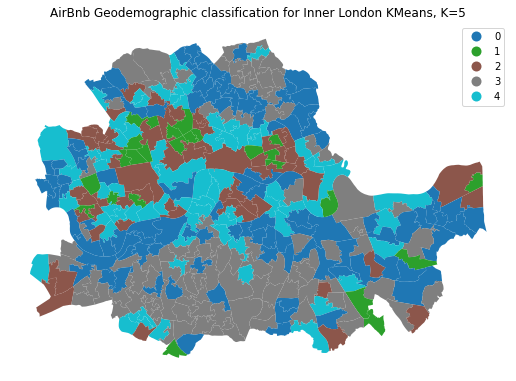

In [ ]:
# Setup figure and ax
f, ax = plt.subplots(1, figsize=(9, 9))
# Plot unique values choropleth including a legend and with no boundary lines
abb.plot(column='k5cls', categorical=True, legend=True, linewidth=0, ax=ax)
# Remove axis
ax.set_axis_off()
# Add title
plt.title('AirBnb Geodemographic classification for Inner London KMeans, K=5')
# Display the map
plt.show()

The map above represents the geographical distribution of the five categories created by the K-means algorithm. A quick glance shows a strong spatial structure in the distribution of the colors: group zero (blue) is mostly found in the city centre and barely in the periphery, while group one (green) is concentrated in the south mostly. Group four (turquoise) is an intermediate one, while group two (brown) is much smaller, containing only a handful of observations.

### Exploring the nature of the categories

Once we have a sense of where and how the categories are distributed over space, it is also useful to explore them statistically. This will allow us to characterize them, giving us an idea of the kind of observations subsumed into each of them. As a first step, let us find how many observations are in each category. To do that, we will make use of the `groupby` operator introduced before, combined with the function `size`, which returns the number of elements in a subgroup:

In [ ]:
k5sizes = abb.groupby('k5cls').size()
k5sizes

k5cls
0    104
1     24
2     55
3     98
4     72
dtype: int64

The `groupby` operator groups a table (`DataFrame`) using the values in the column provided (`k5cls`) and passes them onto the function provided aftwerards, which in this case is `size`. Effectively, what this does is to groupby the observations by the categories created and count how many of them each contains. For a more visual representation of the output, a bar plot is a good alternative:

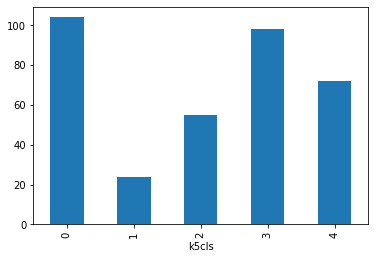

In [ ]:
_ = k5sizes.plot.bar()

As we suspected from the map, groups varying sizes, with groups zero, three and four being over 75 observations each, and one and two being under twenty.

In order to describe the nature of each category, we can look at the values of each of the attributes we have used to create them in the first place. Remember we used the average ratings on many aspects (cleanliness, communication of the host, etc.) to create the classification, so we can begin by checking the average value of each. To do that in Python, we will rely on the `groupby` operator which we will combine it with the function `mean`:

In [ ]:
# Calculate the mean by group
k5means = abb.groupby('k5cls')[ratings].mean()
# Show the table transposed (so it's not too wide)
k5means.T

k5cls,0,1,2,3,4
review_scores_rating,93.727497,88.372825,90.747184,95.330624,92.134328
review_scores_accuracy,9.605591,9.149851,9.359094,9.717272,9.472732
review_scores_cleanliness,9.328059,8.917600,9.132463,9.478406,9.214409
review_scores_checkin,9.679087,9.414038,9.511927,9.785712,9.588242
review_scores_communication,9.722030,9.443715,9.545185,9.804255,9.627248
review_scores_location,9.443591,9.468635,9.442282,9.539375,9.546235
review_scores_value,9.384535,8.898841,9.095480,9.531206,9.220018


This concludes the section on geodemographics. As we have seen, the essence of this approach is to group areas based on a purely statistical basis: *where* each area is located is irrelevant for the label it receives from the clustering algorithm. In many contexts, this is not only permissible but even desirable, as the interest is to see if particular combinations of values are distributed over space in any discernible way. However, in other context, we may be interested in created groups of observations that follow certain spatial constraints. For that, we now turn into regionalization techniques.

However, this approach quickly gets out of hand: more detailed profiles can simply return to an unwieldy mess of numbers. A better approach to constructing cluster profiles is be to draw the distributions of cluster members’ data. To do this we need to “tidy up” the dataset. A tidy dataset (Wickham, 2014) is one where every row is an observation, and every column is a variable. Thus, a few steps are required to tidy up our labelled data:

In [ ]:
# Index db on cluster ID
tidy_db = abb.set_index('k5cls')
# Keep only variables used for clustering
tidy_db = tidy_db[ratings]
# Stack column names into a column, obtaining 
# a "long" version of the dataset
tidy_db = tidy_db.stack()
# Take indices into proper columns
tidy_db = tidy_db.reset_index()
# Rename column names
tidy_db = tidy_db.rename(columns={'level_1': 'Attribute', 0: 'Values'})
# Check out result
tidy_db.head()

,k5cls,Attribute,Values
0,2,review_scores_rating,90.836858
1,2,review_scores_accuracy,9.386707
2,2,review_scores_cleanliness,9.280120
3,2,review_scores_checkin,9.498489
4,2,review_scores_communication,9.425982


Now we are ready to plot. Below, we’ll show the distribution of each cluster’s values for each variable. This gives us the full distributional profile of each cluster:

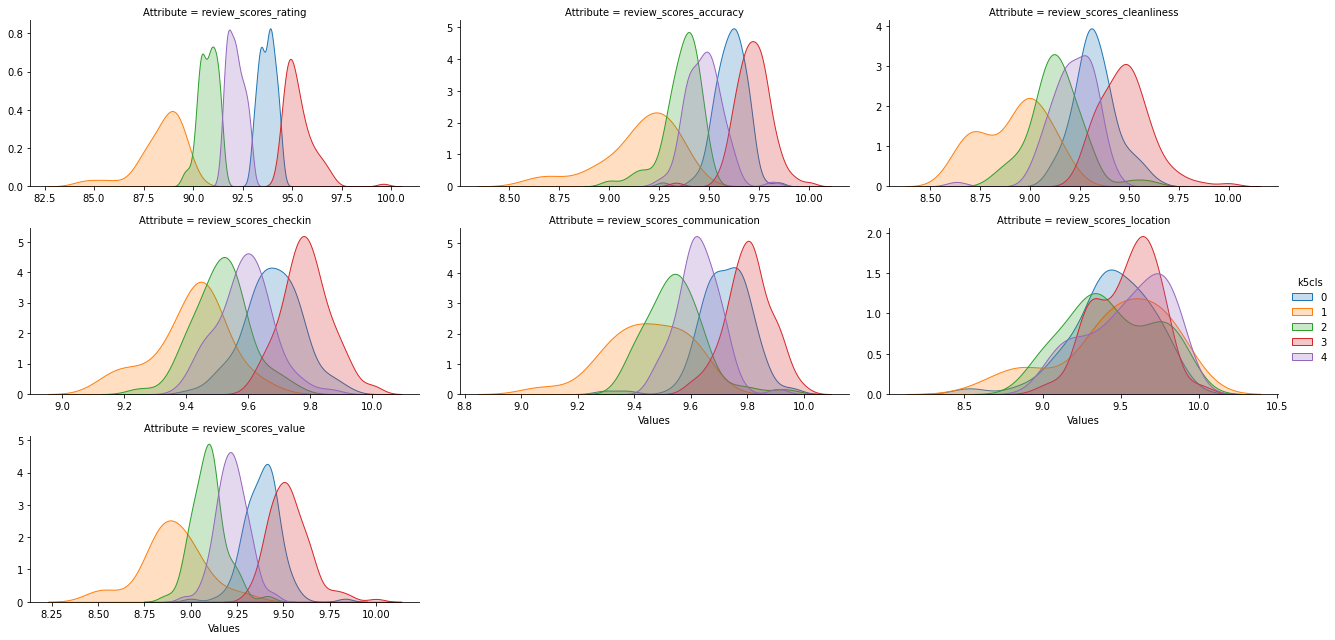

In [ ]:
# Setup the facets
facets = sns.FacetGrid(data=tidy_db, col='Attribute', hue='k5cls', \
                  sharey=False, sharex=False, aspect=2, col_wrap=3)
# Build the plot from `sns.kdeplot`
_ = facets.map(sns.kdeplot, 'Values', shade=True).add_legend()

Taken altogether, these graphs allow us to start delving into the multidimensional complexity of each cluster and the types of areas behind them.



### Regionalization

In the context of explicitly spatial questions, a related concept, the region, is also instrumental. A region is similar to a cluster, in the sense that all members of a region have been grouped together, and the region should provide a shorthand for the original data. Further, for a region to be analytically useful, its members also should display stronger similarity to each other than they do to the members of other regions. However, regions are more complex than clusters because they combine this similarity in profile with additional information about the geography of their members. In short, regions are like clusters (since they have a coherent profile), but they also have a coherent geography—members of a region should also be located near one another.

The process of creating regions is called **regionalization**. A regionalization is a special kind of clustering where the objective is to group observations which are similar in their statistical attributes, but also in their spatial location. In this sense, regionalization embeds the same logic as standard clustering techniques, but also applies a series of spatial and/or geographical constraints. Often, these constraints relate to connectivity: two candidates can only be grouped together in the same region if there exists a path from one member to another member that never leaves the region. These paths often model the spatial relationships in the data, such as contiguity or proximity. However, connectivity does not always need to hold for all regions, and in certain contexts it makes sense to relax connectivity or to impose different types of spatial constraints.

In the case of analysing spatial data, there is a subset of methods that are of particular interest for many common cases in Geographic Data Science. These are the so-called *regionalization* techniques. Regionalization methods can take also many forms and faces but, at their core, they all involve statistical clustering of observations with the additional constraint that observations need to be geographical neighbors to be in the same category. Because of this, rather than category, we will use the term *area* for each observation and *region* for each category, hence regionalization, the construction of regions from smaller areas.

Regionalization is the subset of clustering techniques that impose a spatial constraint on the classification. In other words, the result of a regionalization algorithm contains areas that are spatially contiguous. Efectively, what this means is that these techniques aggregate areas into a smaller set of larger ones, called regions. In this context then, areas are *nested* within regions. Real world examples of this phenomenon includes counties within states or, in the UK, local super output areas (LSOAs) into middle super output areas (MSOAs). The difference between those examples and the output of a regionalization algorithm is that while the former are aggregated based on administrative principles, the latter follows a statistical technique that, very much the same as in the standard statistical clustering, groups together areas that are similar on the basis of a set of attributes. Only that now, such statistical clustering is spatially constrained.

As in the non-spatial case, there are many different algorithms to perform regionalization, and they all differ on details relating to the way they measure (dis)similarity, the process to regionalize, etc. However, same as above too, they all share a few common aspects. In particular, they all take a set of input attributes *and* a representation of space in the form of a binary spatial weights matrix. Depending on the algorithm, they also require the desired number of output regions into which the areas are aggregated.

To illustrate these concepts, we will run a regionalization algorithm on the AirBnb data we have been using. In this case, the goal will be to re-delineate the boundary lines of the Inner London boroughs following a rationale based on the different average ratings on AirBnb proeperties, instead of the administrative reasons behind the existing boundary lines. In this way, the resulting regions will represent a consistent set of areas that are similar with each other in terms of the ratings received.

### Defining space formally

Very much in the same way as with ESDA techniques, regionalization methods require a formal representation of space that is statistics-friendly. In practice, this means that we will need to create a spatial weights matrix for the areas to be aggregated. 

Technically speaking, this is the same process as we have seen before, thanks to `PySAL`. The difference in this case is that we did not begin with a shapefile, but with a GeoJSON. Fortunately, `PySAL` supports the construction of spatial weights matrices "on-the-fly", that is from a table. This is a one-liner:

In [ ]:
w = weights.Queen.from_dataframe(abb)

### Creating regions from areas

At this point, we have all the pieces needed to run a regionalization algorithm. For this example, we will use a spatially-constrained version of the agglomerative algorithm. This is a similar approach to that used above (the inner-workings of the algorithm are different however) with the difference that, in this case, observations can only be labelled in the same group if they are spatial neighbors, as defined by our spatial weights matrix `w`. The way to interact with the algorithm is very similar to that above.

Agglomerative clustering works by building a hierarchy of clustering solutions that starts with all singletons (each observation is a single cluster in itself) and ends with all observations assigned to the same cluster. These extremes are not very useful in themselves. But, in between, the hierarchy contains many distinct clustering solutions with varying levels of detail. The intuition behind the algorithm is also rather straightforward:

1. begin with everyone as part of its own cluster;

2. find the two closest observations based on a distance metric (e.g. euclidean);

3. join them into a new cluster;

4. repeat steps 2) and 3) until reaching the degree of aggregation desired.

The algorithm is thus called “agglomerative” because it starts with individual clusters and “agglomerates” them into fewer and fewer clusters containing more and more observations each. Also, like with k-means, AHC does require the user to specify a number of clusters in advance. This is because, following from the mechanism the method has to build clusters, AHC can provide a solution with as many clusters as observations (k=n), or with a only one (k=1).

In [ ]:
sagg13 = cluster.AgglomerativeClustering(n_clusters=13, connectivity=w.sparse)
sagg13

AgglomerativeClustering(connectivity=<353x353 sparse matrix of type '<class 'numpy.float64'>'
	with 1978 stored elements in Compressed Sparse Row format>,
                        n_clusters=13)

And we can run the algorithm by calling `fit`:

In [ ]:
# Run the clustering algorithm
sagg13cls = sagg13.fit(abb[ratings])

And then we append the labels to the table:

In [ ]:
abb['sagg13cls'] = sagg13cls.labels_

### Mapping the resulting regions

At this point, the column `sagg13cls` is no different than `k5cls`: a categorical variable that can be mapped into a unique values choropleth. In fact the following code snippett is exactly the same as before, only replacing the name of the variable to be mapped and the title:

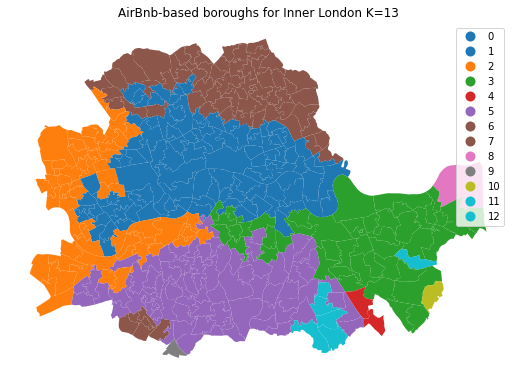

In [ ]:
# Setup figure and ax
f, ax = plt.subplots(1, figsize=(9, 9))
# Plot unique values choropleth including a legend and with no boundary lines
abb.plot(column='sagg13cls', categorical=True, legend=True, linewidth=0, ax=ax)
# Remove axis
ax.set_axis_off()
# Add title
plt.title('AirBnb-based boroughs for Inner London K=13')
# Display the map
plt.show()

### Changing the spatial constraint
The spatial constraint in regionalization algorithms is structured by the spatial weights matrix we use. An interesting question is thus how the choice of weights influences the final region structure. Fortunately, we can directly explore the impact that a change in the spatial weights matrix has on regionalization. To do so, we use the same attribute data but replace the Queen contiguity matrix with a spatial k-nearest neighbor matrix, where each observation is connected to its four nearest observations, instead of those it touches.

In [ ]:
w = KNN.from_dataframe(abb, k=4)

With this matrix connecting each tract to the four closest tracts, we can run another AHC regionalization:

In [ ]:
np.random.seed(123456)
model = AgglomerativeClustering(linkage='ward',connectivity=w.sparse,n_clusters=5)
model.fit(abb[ratings])

AgglomerativeClustering(connectivity=<353x353 sparse matrix of type '<class 'numpy.float64'>'
	with 1412 stored elements in Compressed Sparse Row format>,
                        n_clusters=5)

And plot the final regions:

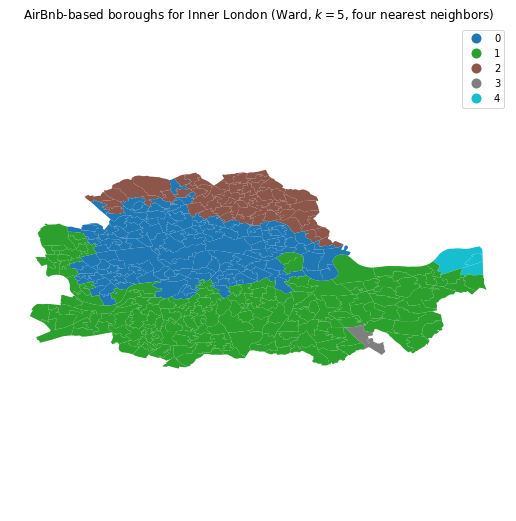

In [ ]:
abb['ward5wknn'] = model.labels_
# Setup figure and ax
f, ax = plt.subplots(1, figsize=(9, 9))
# Plot unique values choropleth including a legend and with no boundary lines
abb.plot(column='ward5wknn', categorical=True, legend=True, linewidth=0, ax=ax)
# Remove axis
ax.set_axis_off()
# Keep axes proportionate
plt.axis('equal')
# Add title
plt.title('AirBnb-based boroughs for Inner London (Ward, $k=5$, four nearest neighbors)')
# Display the map
plt.show()

Even though we have specified a spatial constraint, the constraint applies to the connectivity graph modeled by our weights matrix. Therefore, using k-nearest neighbors to constrain the agglomerative clustering may not result in regions that are connected according to a different connectivity rule, such as the queen contiguity rule used in the previous section. However, the regionalization here is fortuitous; even though we used the 4-nearest tracts to constrain connectivity, all but one of the clusters, cluster 4, is also connected according to our earlier queen contiguity rule.

At first glance, this may seem counter-intuitive. We did specify the spatial constraint, so our initial reaction is that the connectivity constraint is violated. However, this is not the case, since the constraint applies to the k-nearest neighbor graph, not the queen contiguity graph. Therefore, since tracts in this solution are considered as connected to their four closest neighbors, clusters can “leapfrog” over one another. Thus, it is important to recognize that the apparent spatial structure of regionalizations will depend on how the connectivity of observations is modeled.


### Comparing organic and administrative delineations

The map above gives a very clear impression of the boundary delineation of the algorithm. However, it is still based on the small area polygons. To create the new boroughs "properly", we need to dissolve all the polygons in each category into a single one. This is a standard GIS operation that is supported by `geopandas` and that can be easily actioned with the same `groupby` operator we used before. The only additional complication is that we need to wrap it into a separate function to be able to pass it on to `groupby`. We first the define the function `dissolve`:

In [ ]:
def dissolve(gs):
    '''
    Take a series of polygons and dissolve them into a single one
    
    Arguments
    ---------
    gs        : GeoSeries
                Sequence of polygons to be dissolved
    Returns
    -------
    dissolved : Polygon
                Single polygon containing all the polygons in `gs`
    '''
    return gs.unary_union

The boundaries for the AirBnb boroughs can then be obtained as follows:

In [ ]:
# Dissolve the polygons based on `sagg13cls`
abb_boroughs = gpd.GeoSeries(abb.groupby(abb['sagg13cls'])\
                                .apply(dissolve),
                             crs=abb.crs
                            )

Which we can plot:

Text(0.5, 1.0, 'AirBnb-based boroughs for Inner London')

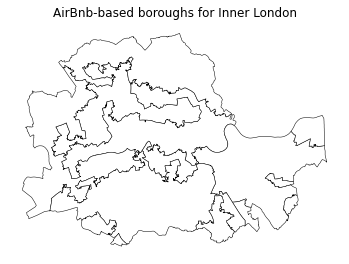

In [ ]:
# Setup figure and ax
f, ax = plt.subplots(1, figsize=(6, 6))
# Plot boundary lines
abb_boroughs.plot(ax=ax, 
                  linewidth=0.5,
                  facecolor='white', 
                  edgecolor='k'
                 )
# Remove axis
ax.set_axis_off()
# Add title
plt.title('AirBnb-based boroughs for Inner London')

The delineation above provides a view into the geography of AirBnb properties. Each region delineated contains houses that, according to our regionalisation algorithm, are more similar with each other than those in the neighboring areas. Now let's compare this geography that we have organically drawn from our data with that of the official set of administrative boundaries. For example, with the London boroughs.

Remember we read these at the beginning of the notebook:

In [ ]:
boroughs.head()

,NAME,GSS_CODE,HECTARES,NONLD_AREA,ONS_INNER,SUB_2009,SUB_2006,geometry
0,Lambeth,E09000022,2724.940,43.927,T,None,None,"POLYGON ((-0.12846 51.48505, -0.12843 51.48506..."
1,Southwark,E09000028,2991.340,105.139,T,None,None,"POLYGON ((-0.10892 51.50844, -0.10889 51.50845..."
2,Lewisham,E09000023,3531.706,16.795,T,None,None,"POLYGON ((-0.03241 51.49306, -0.03240 51.49303..."
3,Greenwich,E09000011,5044.190,310.785,F,None,None,"MULTIPOLYGON (((-0.02485 51.48555, -0.02479 51..."
4,Wandsworth,E09000032,3522.022,95.600,T,None,None,"POLYGON ((-0.22343 51.47152, -0.22327 51.47146..."


And displayed in a similar way as with the newly created ones:

Text(0.5, 1.0, 'Administrative boroughs for Inner London')

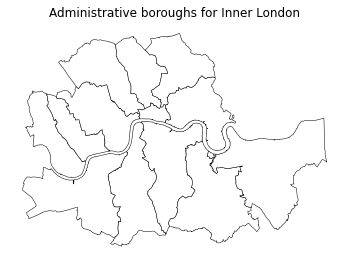

In [ ]:
# Setup figure and ax
f, ax = plt.subplots(1, figsize=(6, 6))
# Plot boundary lines
boroughs.plot(ax=ax, 
              linewidth=0.5,
              edgecolor='k', 
              facecolor='white'
             )
# Remove axis
ax.set_axis_off()
# Add title
plt.title('Administrative boroughs for Inner London')

In order to more easily compare the administrative and the "regionalized" boundary lines, we can overlay them:

```{margin}
The code to create this figure is hidden to facilitate the flow of the narrative but you can toggle it open. It combines building blocks we have seen previously in this course
```

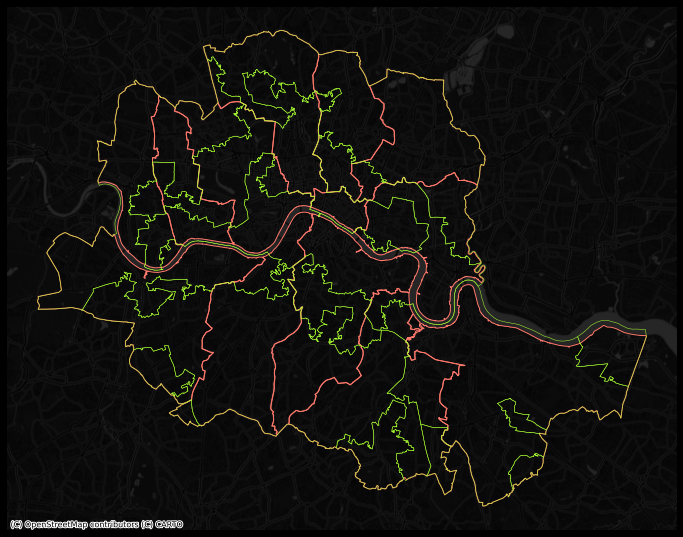

In [ ]:
# Set up figure
f, ax = plt.subplots(1, figsize=(12, 12))
f.set_facecolor("k")

# Add boroughs
boroughs.to_crs(epsg=22770)\
        .plot(ax=ax,
              facecolor="none",
              edgecolor="xkcd:salmon",
              linewidth=1
             )

# Add regionalisation geography
abb_boroughs.to_crs(epsg=22770)\
            .plot(ax=ax,
                  facecolor="none",
                  edgecolor="xkcd:lime",
                  linewidth=0.5
                 )

# Add basemap
cx.add_basemap(ax,
               crs="EPSG:22770",
               source=cx.providers.CartoDB.DarkMatterNoLabels
              )

# Remove axis
ax.set_axis_off()
# Display clean
plt.show()

Looking at the figure, there are several differences between the two maps. The clearest one is that, while the administrative boundaries have a very balanced size (with the exception of the city of London), the regions created with the spatial agglomerative algorithm are very different in terms of size between each other. This is a consequence of both the nature of the underlying data and the algorithm itself. Substantively, this shows how, based on AirBnb, we can observe large areas that are similar and hence are grouped into the same region, while there also exist pockets with characteristics different enough to be assigned into a different region.

Overall, clustering and regionalization are two complementary tools to reduce the complexity in multivariate data and build better understandings of the spatial structure of data. Often, there is simply too much data to examine every variables’ map and its relation to all other variable maps. Thus, clustering reduces this complexity into a single conceptual shorthand by which people can easily describe complex and multifaceted data. Clustering constructs groups of observations (called clusters) with coherent profiles, or distinct and internally-consistent distributional/descriptive characteristics. These profiles are the conceptual shorthand, since members of each cluster should be more similar to the cluster at large than they are to any other cluster. Many different clustering methods exist; they differ on how the “cluster at large” is defined, and how “similar” members must be to clusters, or how these clusters are obtained. Regionalization is a special kind of clustering with an additional geographic requirement. Observations should be grouped so that each spatial cluster, or region, is spatially-coherent as well as data-coherent. Thus, regionalization is often concerned with connectivity in a contiguity graph for data collected in areas; this ensures that the regions that are identified are fully internally-connected. However, since many regionalization methods are defined for an arbitrary connectivity structure, these graphs can be constructed according to different rules as well, such as the k-nearest neighbor graph.

In this notebook, we discussed the conceptual basis for clustering and regionalization, as well showing why clustering is done. Further, we have shown how to build clusters using spatial data science packages, and how to interrogate the meaning of these clusters as well. More generally, clusters are often used in predictive and explanatory settings, in addition to being used for exploratory analysis in their own right. Clustering and regionalization are intimately related to the analysis of spatial autocorrelation as well, since the spatial structure and covariation in multivariate spatial data is what determines the spatial structure and data profile of discovered clusters or regions. Thus, clustering and regionalization are essential tools for the spatial data scientist.

